<a href="https://colab.research.google.com/github/jjpeh/W207/blob/dev_code/W207_Home_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W207 Final Project: Home Price Prediction

## Import Libraries

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

# dataset from Kaggle: kaggle competitions download -c house-prices-advanced-regression-techniques

## Import Dataset from Kaggle

In [2]:
#!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
# copy the API key to the kaggle directory
!cp kaggle.json ~/.kaggle/
# list all kaggle api dataset
#!kaggle datasets list
# download dataset from kaggle for the first time
!kaggle competitions download -c house-prices-advanced-regression-techniques
!ls

Saving kaggle.json to kaggle (1).json
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt: Skipping, found more recently modified local copy (use --force to force download)
 data_description.txt   kaggle.json   sample_submission.csv   train.csv
'kaggle (1).json'       sample_data   test.csv


In [3]:
# read train and test dataset into dataframe
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
train_df.head(10)
#test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [0]:
#Split test data into development and test data
num_test_half = int(test_df.shape[0]/2)
dev_df = test_df.iloc[:num_test_half]
final_test_df =  test_df.iloc[num_test_half:]

In [0]:
#drop Id column which is not relevant to what we will be using
train_df.drop(['Id'], axis = 1, inplace = True)

## EXPLORATORY DATA ANALYSIS (EDA)

### Initial Features Study

In [6]:
# look at all features available
train_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Text(0.5, 1.0, 'Bar Chart of Home Features with Most Missing Values')

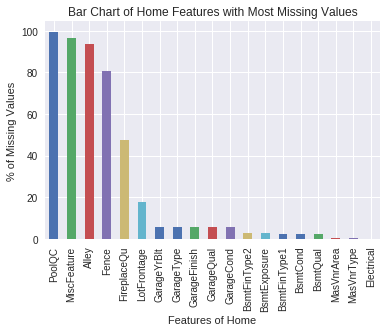

In [7]:
# check for null value in features

null_feature = train_df.isnull().sum()
pcnt_null = null_feature/(len(train_df))*100   # convert to % missing
pcnt_null = pcnt_null[pcnt_null>0]     # only display features with missing values
pcnt_null.sort_values(inplace=True, ascending=False)
pcnt_null.plot.bar()
plt.xlabel("Features of Home")
plt.ylabel("% of Missing Values")
plt.title("Bar Chart of Home Features with Most Missing Values")

In [8]:
# select top NA features to drop from study
null_features_to_drop = pcnt_null.index[0:5]
null_features_to_drop

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], dtype='object')

There're some features with a lot of missing values in the dataset, which could be a disturbance to our study. The 5 features with highest missing values are dropped.

In [0]:
# Drop features with much null values in the dataframe
train_df.drop(null_features_to_drop, axis = 1, inplace = True)

In [10]:
# split categorical and numerical features
cat_features = train_df.select_dtypes(include=['object'])
#cat_features.head()
num_features = train_df.select_dtypes(exclude=['object'])
#num_features.head()
print("categorical features:", len(cat_features.columns))
print("numerical features:", len(num_features.columns))

categorical features: 38
numerical features: 37


### Correlation Analysis: 
####Select top 25 features with highest correlation with Sale Price

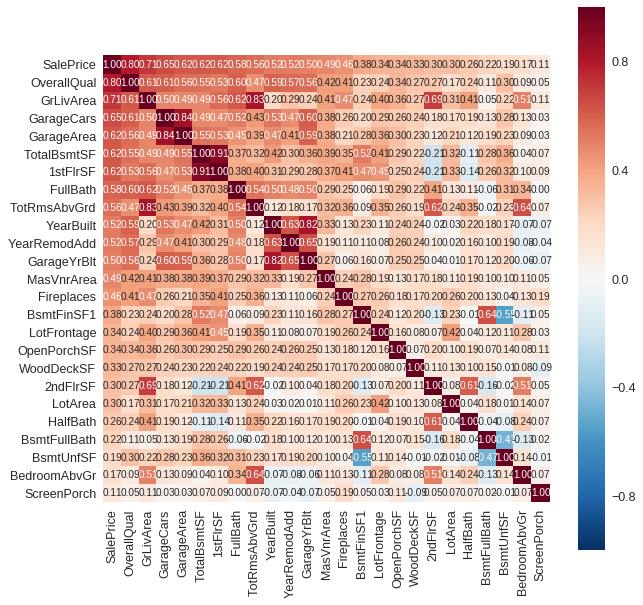

In [25]:
# Top 25 Heatmap
k = 25 #number of variables for heatmap
#drop null values for correlation calculation
train_df_nonull = train_df.dropna()  
corrmat = train_df_nonull.corr()
hi_cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df_nonull[hi_cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=hi_cols.values, xticklabels=hi_cols.values, ax = ax)
plt.show()

In [76]:
# assign top 25 features that correlates to Sales Price in new dataframe
#top25_df = train_df[hi_cols[1:]]   # slice out SalePrice as it's outcome variable
top25_df = train_df_nonull[hi_cols]
top25_df.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,...,LotFrontage,OpenPorchSF,WoodDeckSF,2ndFlrSF,LotArea,HalfBath,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,ScreenPorch
0,208500,7,1710,2,548,856,856,2,8,2003,...,65.0,61,0,854,8450,1,1,150,3,0
1,181500,6,1262,2,460,1262,1262,2,6,1976,...,80.0,0,298,0,9600,0,0,284,3,0
2,223500,7,1786,2,608,920,920,2,6,2001,...,68.0,42,0,866,11250,1,1,434,3,0
3,140000,7,1717,3,642,756,961,1,7,1915,...,60.0,35,0,756,9550,0,1,540,3,0
4,250000,8,2198,3,836,1145,1145,2,9,2000,...,84.0,84,192,1053,14260,1,1,490,4,0


In [77]:
# split categorical and numerical features AGAIN
cat_features2 = top25_df.select_dtypes(include=['object'])
#cat_features2.head()
num_features2 = top25_df.select_dtypes(exclude=['object'])
#num_features2.head()
print("categorical features of top 25:", len(cat_features2.columns))
print("numerical features of top 25:", len(num_features2.columns))

categorical features of top 25: 0
numerical features of top 25: 25


### Numerical Data Analysis (JJ)

In [78]:
# summary of top features with numeric values
top25_df.describe()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,...,LotFrontage,OpenPorchSF,WoodDeckSF,2ndFlrSF,LotArea,HalfBath,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,ScreenPorch
count,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,...,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000
mean,187033.263254,6.247715,1535.027422,1.879342,503.760512,1099.561243,1173.809872,1.577697,6.570384,1972.412249,...,70.759598,46.946984,94.341865,356.536563,10132.346435,0.389397,0.423218,606.117002,2.861974,16.498172
std,83165.332151,1.366797,526.124028,0.658586,192.261314,415.851262,387.677463,0.550219,1.584486,31.189752,...,24.508859,64.820019,122.624615,439.260130,8212.249621,0.500793,0.514253,445.834636,0.764107,58.455303
min,35311.000000,2.000000,438.000000,1.000000,160.000000,105.000000,438.000000,0.000000,3.000000,1880.000000,...,21.000000,0.000000,0.000000,0.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,132500.000000,5.000000,1164.000000,1.000000,360.000000,816.000000,894.000000,1.000000,5.000000,1953.000000,...,60.000000,0.000000,0.000000,0.000000,7606.750000,0.000000,0.000000,270.000000,2.000000,0.000000
50%,165750.000000,6.000000,1480.000000,2.000000,484.000000,1023.000000,1097.000000,2.000000,6.000000,1975.000000,...,70.000000,28.000000,0.000000,0.000000,9444.500000,0.000000,0.000000,525.000000,3.000000,0.000000
75%,221000.000000,7.000000,1779.000000,2.000000,602.500000,1345.500000,1413.500000,2.000000,7.000000,2003.000000,...,80.000000,68.000000,169.750000,729.000000,11387.250000,1.000000,1.000000,846.000000,3.000000,0.000000
max,755000.000000,10.000000,5642.000000,4.000000,1418.000000,6110.000000,4692.000000,3.000000,12.000000,2010.000000,...,313.000000,547.000000,857.000000,2065.000000,215245.000000,2.000000,2.000000,2336.000000,6.000000,480.000000


- Lot frontage (linear feet of street connected to property) has lesser count
- lot area has big variation
- sales prices have some outliers
- MSSubClass should be categorical variable instead of numeric


##### Analysis on Outcome Variable: Sales Price

Text(0.5, 1.0, 'Histogram of log(Sales Price)')

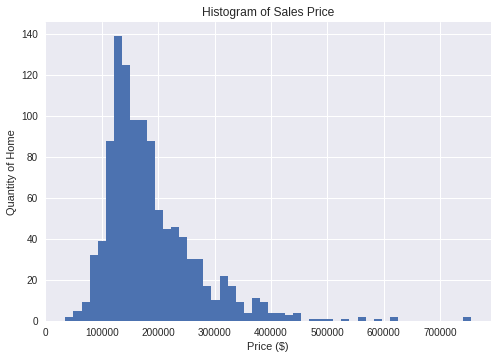

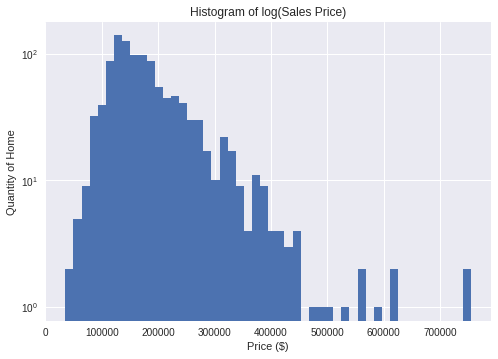

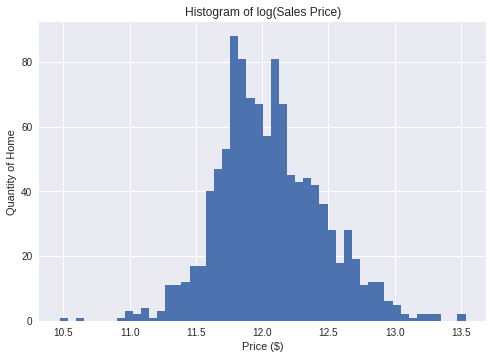

In [81]:
# Transformation on variables
transform_df = top25_df.copy() # create a copy on df to retain original data. transform_df will be used to store log values
transform_df['SalePrice'] = np.log(transform_df['SalePrice'])

# some initial plots on SalesPrice
plt.figure(1)
plt.hist("SalePrice", bins=50, data=top25_df)
plt.xlabel("Price ($)")
plt.ylabel("Quantity of Home")
plt.title("Histogram of Sales Price")

plt.figure(2)
#sns.distplot(top25_df['SalePrice'])
plt.hist("SalePrice", bins=50, data=top25_df, log=True)
plt.xlabel("Price ($)")
plt.ylabel("Quantity of Home")
plt.title("Histogram of log(Sales Price)")

# plot 3 is the expected log transformation
plt.figure(3)
plt.hist("SalePrice", bins=50, data=transform_df, log=False)
plt.xlabel("Price ($)")
plt.ylabel("Quantity of Home")
plt.title("Histogram of log(Sales Price)")

##### Scatter Plot Matrix on Numerical Data

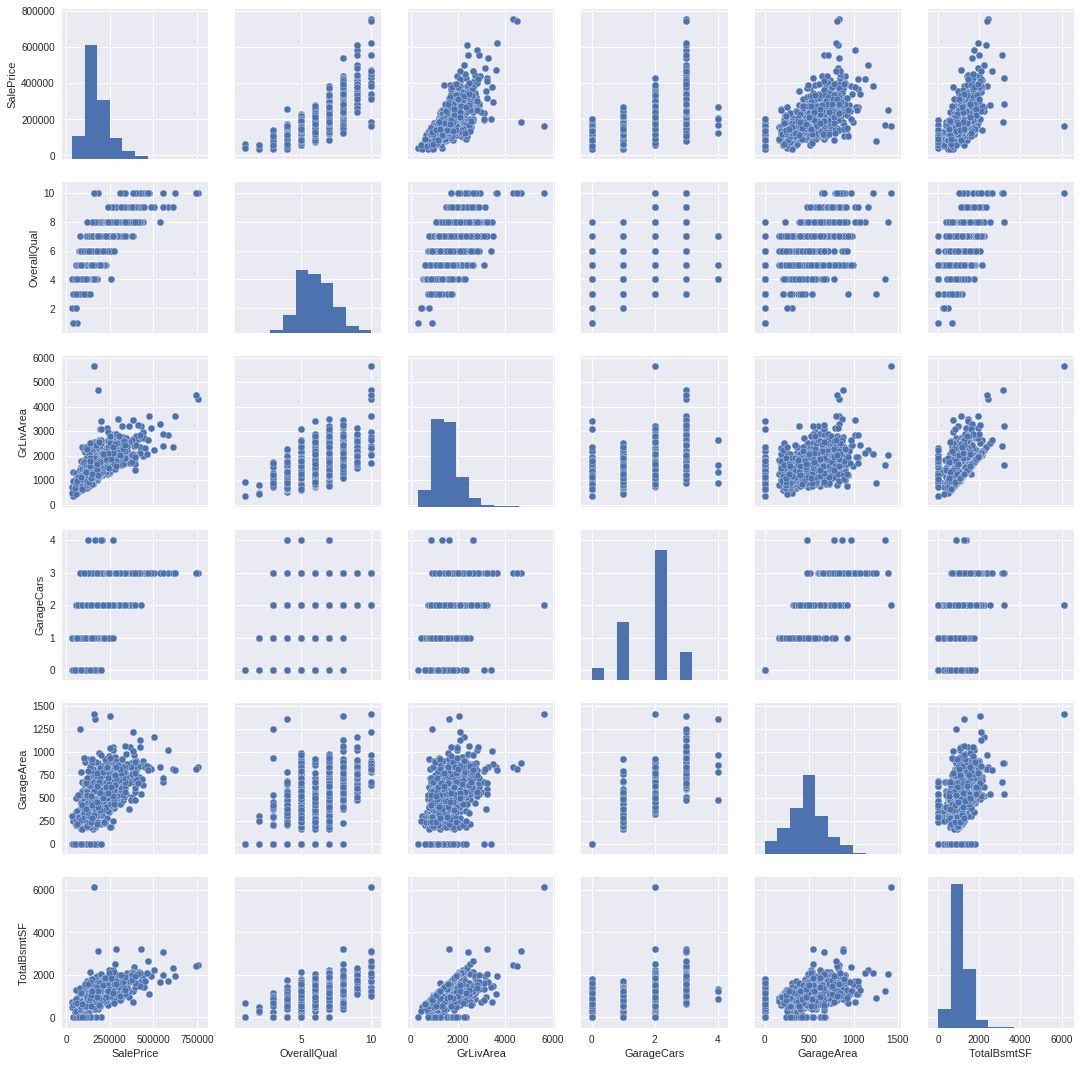

In [47]:
# Look at scatter plot matrix for important variables
sns.set()
scatter1 = hi_cols[0:6] # sales price with top 5 features
sns.pairplot(train_df[scatter1], size = 2.5)

Above are some of the features that could potentially affect the price of home sales price.
- Overall Qual and year of build is linearly correlated to sales price.
- Most of the old houses (year of built) are priced on the lower range.
- Not much correlation between lot area with sales price



##### Bivariate analysis on individual correlation via scatter plots

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


<Figure size 576x396 with 0 Axes>

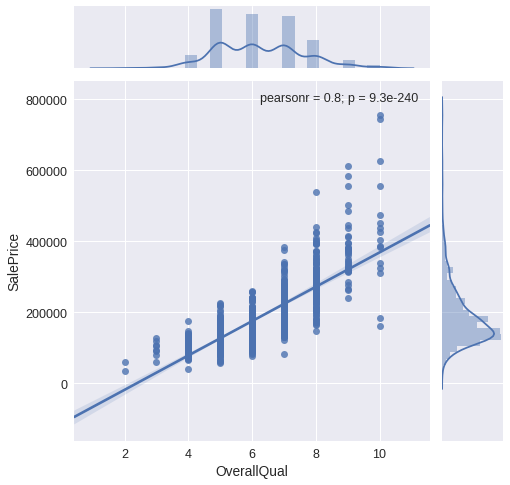

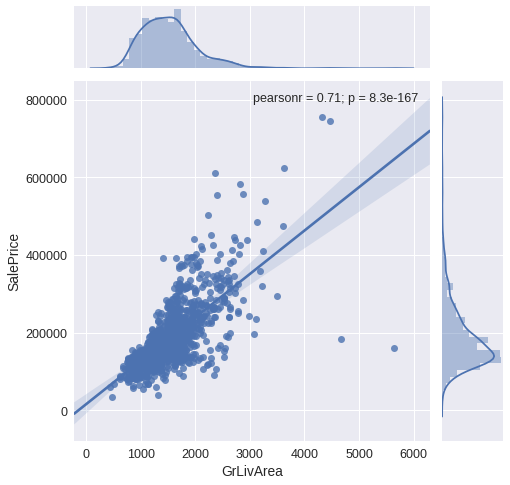

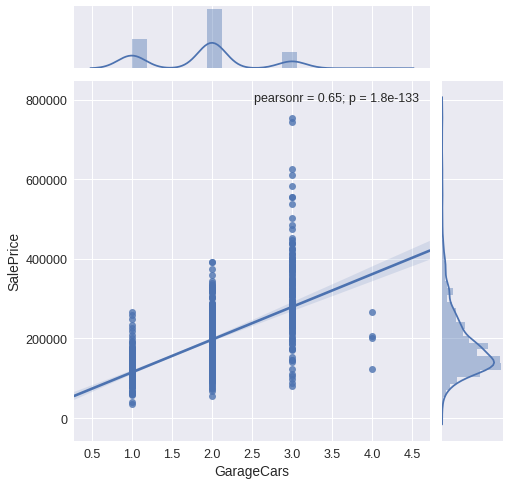

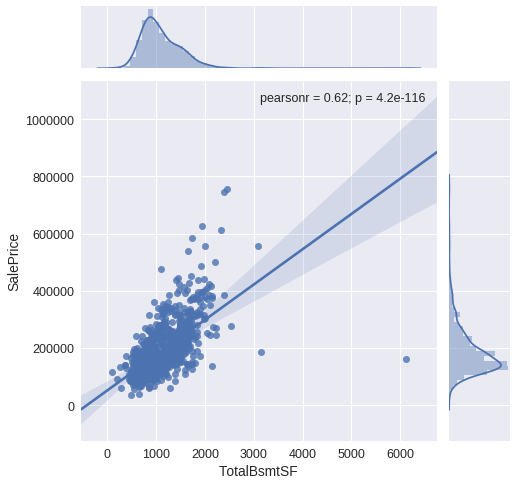

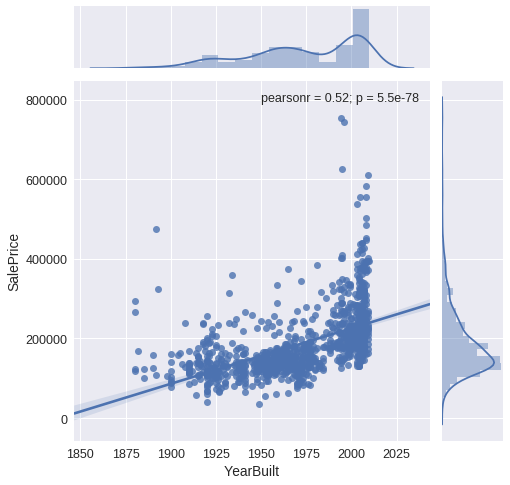

In [39]:
# OverallQual vs SalePrice
plt.figure(1)
sns.jointplot(x="OverallQual", y="SalePrice", data=top25_df, kind = 'reg', size = 7)
plt.figure(2)
sns.jointplot(x="GrLivArea", y="SalePrice", data=top25_df, kind = 'reg', size = 7)
plt.figure(3)
sns.jointplot(x="GarageCars", y="SalePrice", data=top25_df, kind = 'reg', size = 7)
plt.figure(4)
sns.jointplot(x="TotalBsmtSF", y="SalePrice", data=top25_df, kind = 'reg', size = 7)
plt.figure(5)
sns.jointplot(x="YearBuilt", y="SalePrice", data=top25_df, kind = 'reg', size = 7)


Top 5 features having positive linear relationship with sales price. Some outliers at extremely high x-value that needs to be investigated.

##### Outliers Removal

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


<Figure size 576x396 with 0 Axes>

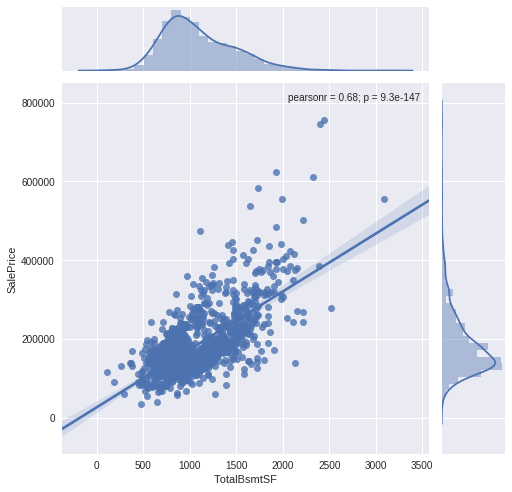

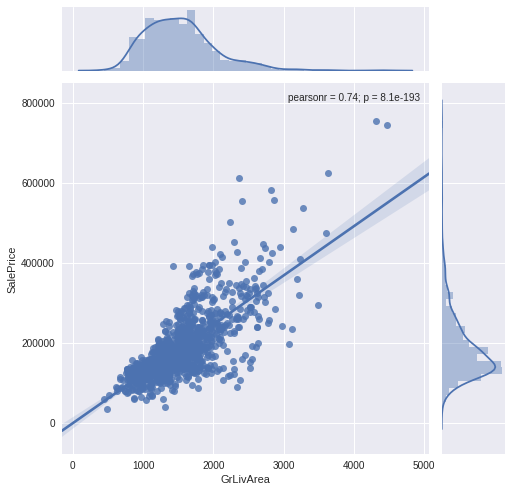

In [70]:
# TotalBsmtSF has outlier at extremely large basement area but low sales price
top25_df = top25_df.drop(top25_df[(top25_df['TotalBsmtSF']>6000)].index)
plt.figure(1)
sns.jointplot(x="TotalBsmtSF", y="SalePrice", data=top25_df, kind = 'reg', size = 7)

# GrLivArea has outliers at area larger than 4000 but price lower than 200000, that don't obey the linear relationship
top25_df = top25_df.drop(top25_df[(top25_df['GrLivArea']>4000) & (top25_df['SalePrice']<200000)].index)
plt.figure(2)
sns.jointplot(x="GrLivArea", y="SalePrice", data=top25_df, kind = 'reg', size = 7)


# Outliers Removal for SalePrice itself???


In [0]:
# save important numeric features here for modeling
good_features_numeric = ['OverallCond', 'YearBuilt']

### Categorical Data (Ploy)

In [0]:
# Plot variables in box plot to look at categorical data
#plt.figure(1)
#sns.boxplot(x='Street', y='SalePrice', data=train_df)
#sns.swarmplot(x='Street', y='SalePrice', data=train_df,color=".25")

# plot alley, need to fill up NA as a new category
#train_df['Alley'] = train_df['Alley'].astype('category')
#if train_df['Alley'].isnull().any():
#  train_df['Alley'] = train_df['Alley'].cat.add_categories(['No_entry'])
#  train_df['Alley'] = train_df['Alley'].fillna('No_entry')
  
#box_features = ['Street', 'Alley', 'MSSubClass', 'MSZoning', 'LotShape']
#for i in box_features:
#  plt.figure(i)
#  sns.boxplot(x=i, y='SalePrice', data=train_df)


### Transformation

### Check for Correlation and Covariance

## FEATURE ENGINEERING

## MODELING

## CONCLUSION

### Discussion on some improvements to be done and omitted variables to be considered

## REFERENCE & ADDITIONAL RESOURCES

References from Kaggle:
- https://www.kaggle.com/harlfoxem/house-price-prediction-part-2
- https://www.kaggle.com/dgawlik/house-prices-eda/notebook
- https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

References on Python:
- https://seaborn.pydata.org/tutorial/distributions.html

#####to create dummies:

https://stackoverflow.com/questions/39173813/pandas-convert-dtype-object-to-int

pd.factorize(df['purchase'])[0]
Example:

labels, uniques = pd.factorize(['b', 'b', 'a', 'c', 'b'])


labels
array([0, 0, 1, 2, 0])


uniques
array(['b', 'a', 'c'], dtype=object)